# Tarea 2 — Gestión del Conocimiento

**Name:** -- Víctor Manuel Mariscal Cervantes --

**e-mail:** -- victor.mariscal4459@alumnos.udg.mx --

**Archivo:** GDC_H2.ipynb


# MODULES

In [4]:
# Asegurar que las librerias existen
%pip install matplotlib
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Cargar módulos (solo estándar + matplotlib para graficar)
import random  # Para generar datos sintéticos
import math    # Para operaciones matemáticas (distancias, etc.)
import matplotlib.pyplot as plt  # Para graficar

%matplotlib inline

# Teoría sobre el algoritmo de Clusterización Secuencial (Leader Algorithm)

La **clusterización secuencial** (también conocida como *leader algorithm*) es un método simple y eficiente para agrupar
observaciones en tiempo lineal con respecto al número de puntos. La idea principal es procesar los puntos uno por uno y
decidir si el punto pertenece a un *líder* (centro) existente o si debe crear un nuevo clúster.

## Definición del problema
Dados puntos $x_i \in \mathbb{R}^d$ y un radio de similitud $R>0$, se buscan grupos tales que los puntos dentro de un mismo
grupo estén a distancia no mayor que $R$ de su centro.

## Algoritmo (versión básica)
1. Inicializa la lista de centros vacía.
2. Para cada punto $x$ en el orden de llegada:
   - Encuentra el centro más cercano $\mu_k$.
   - Si $\text{dist}(x, \mu_k) \le R$, asigna $x$ al clúster $k$ y **actualiza el centro** con el promedio incremental.
   - En caso contrario, **crea un nuevo clúster** con centro $x$.

Usaremos la **distancia Euclidiana** en $\mathbb{R}^2$:
$$ d\big((x,y),(u,v)\big)=\sqrt{(x-u)^2+(y-v)^2}. $$

## Actualización incremental del centro
Si un clúster tiene centro actual $\boldsymbol{\mu}$, soporta $n$ puntos y agregamos un nuevo punto $\mathbf{x}$, el nuevo centro es:
$$ \boldsymbol{\mu}' = \boldsymbol{\mu} + \frac{\mathbf{x} - \boldsymbol{\mu}}{n+1}. $$

## Complejidad
- En el peor caso, si se crean muchos clústeres, la búsqueda del centro más cercano puede costar $O(K)$ por punto (donde $K$ es el número de clústeres formados),
  y el algoritmo completo es $O(NK)$ con $N$ puntos. En práctica, con radios razonables, $K\ll N$ y el método es muy rápido.

## Ventajas y limitaciones
- **Ventajas:** simple, lineal en el flujo de datos, útil en escenarios *online*.
- **Limitaciones:** depende fuertemente del orden de llegada y de la selección del radio $R$; no re-asigna puntos una vez creados los clústeres.

## Funciones auxiliares: distancia y promedio incremental

In [7]:
def euclidean(p, q):
    """Distancia Euclidiana en 2D entre p=(x,y) y q=(u,v)."""
    return math.sqrt((p[0]-q[0])**2 + (p[1]-q[1])**2)

def update_center_incremental(center, n, x):
    """Actualiza el centro (promedio) al agregar un nuevo punto x. n es el conteo actual antes de agregar x."""
    cx, cy = center
    nx = cx + (x[0] - cx) / (n + 1)
    ny = cy + (x[1] - cy) / (n + 1)
    return (nx, ny)

## Implementación pura en Python del algoritmo secuencial

In [12]:
class SequentialClusterer:
    """
    Implementación del algoritmo de clusterización secuencial (leader algorithm) en 2D, sin librerías externas.
    - radius: umbral R para decidir si un punto se agrega a un clúster existente o crea uno nuevo.
    - distance_fn: función de distancia; por defecto, Euclidiana.
    - max_clusters: número máximo de clústeres permitidos (None = sin límite).
    """
    def __init__(self, radius, distance_fn=euclidean, max_clusters=5):
        self.radius = radius
        self.distance_fn = distance_fn
        self.max_clusters = max_clusters
        self.centers = []   # Lista de centros (tuplas (x,y))
        self.counts = []    # Tamaño de cada clúster
        self.assignments_ = []  # Índice de clúster para cada punto en el mismo orden de entrada

    def fit(self, data):
        assignments = []
        for x in data:
            if not self.centers:
                # Primer punto crea el primer clúster
                self.centers.append(x)
                self.counts.append(1)
                assignments.append(0)
                continue

            # Buscar centro más cercano
            best_k = None
            best_d = float('inf')
            for k, c in enumerate(self.centers):
                d = self.distance_fn(x, c)
                if d < best_d:
                    best_d = d
                    best_k = k

            # Decisión según el radio
            if best_d <= self.radius:
                # Asignar al clúster existente y actualizar centro
                n = self.counts[best_k]
                self.centers[best_k] = update_center_incremental(self.centers[best_k], n, x)
                self.counts[best_k] = n + 1
                assignments.append(best_k)
            else:
                # Solo crear un nuevo clúster si no hemos alcanzado el límite
                if self.max_clusters is None or len(self.centers) < self.max_clusters:
                    self.centers.append(x)
                    self.counts.append(1)
                    assignments.append(len(self.centers) - 1)
                else:
                    # Si ya alcanzamos el máximo, asignamos al centro más cercano
                    n = self.counts[best_k]
                    self.centers[best_k] = update_center_incremental(self.centers[best_k], n, x)
                    self.counts[best_k] = n + 1
                    assignments.append(best_k)

        self.assignments_ = assignments
        return assignments

    def predict(self, points):
        """Asigna nuevos puntos al centro más cercano (sin modificar los centros)."""
        result = []
        for x in points:
            best_k = None
            best_d = float('inf')
            for k, c in enumerate(self.centers):
                d = self.distance_fn(x, c)
                if d < best_d:
                    best_d = d
                    best_k = k
            result.append(best_k)
        return result


## Generación de datos sintéticos (sin NumPy)

Para ilustrar, generaremos tres "nubes" de puntos en 2D usando `random.gauss(μ, σ)` de la librería estándar.
Esto **no** requiere librerías externas.

In [13]:
def generar_blobs(seed=42):
    random.seed(seed)
    blobs = []
    # Centros verdaderos (solo para simular datos)
    centros = [(-2.5, 0.0), (2.5, 0.5), (0.0, 3.0)]
    sigmas = [0.6, 0.5, 0.7]
    tamanos = [80, 70, 90]
    for (mx, my), s, n in zip(centros, sigmas, tamanos):
        for _ in range(n):
            x = random.gauss(mx, s)
            y = random.gauss(my, s)
            blobs.append((x, y))
    return blobs

datos = generar_blobs()
len(datos)  # número total de puntos

240

## Ejecutar el algoritmo

Elegimos un radio $R$ razonable según la dispersión simulada (por ejemplo, `R = 1.2`).
Valores muy pequeños crearán muchos clústeres; valores muy grandes mezclarán distintos grupos.

In [14]:
R = 1.2  # radio de similitud
sc = SequentialClusterer(radius=R)
asignaciones = sc.fit(datos)

print("Número de clústeres formados:", len(sc.centers))
for i, (c, n) in enumerate(zip(sc.centers, sc.counts)):
    print(f"Cluster {i}: tamaño={n}, centro aproximado={c}")

Número de clústeres formados: 5
Cluster 0: tamaño=54, centro aproximado=(-2.3127957345432795, -0.18758082175389987)
Cluster 1: tamaño=7, centro aproximado=(-3.5452419323399096, -0.10737180899301925)
Cluster 2: tamaño=22, centro aproximado=(-1.931171635710995, 1.3640166453542688)
Cluster 3: tamaño=79, centro aproximado=(-0.05768785156584864, 2.8702174825293305)
Cluster 4: tamaño=78, centro aproximado=(2.31901101450758, 0.7932952478898083)


## Visualización 2D de los clústeres

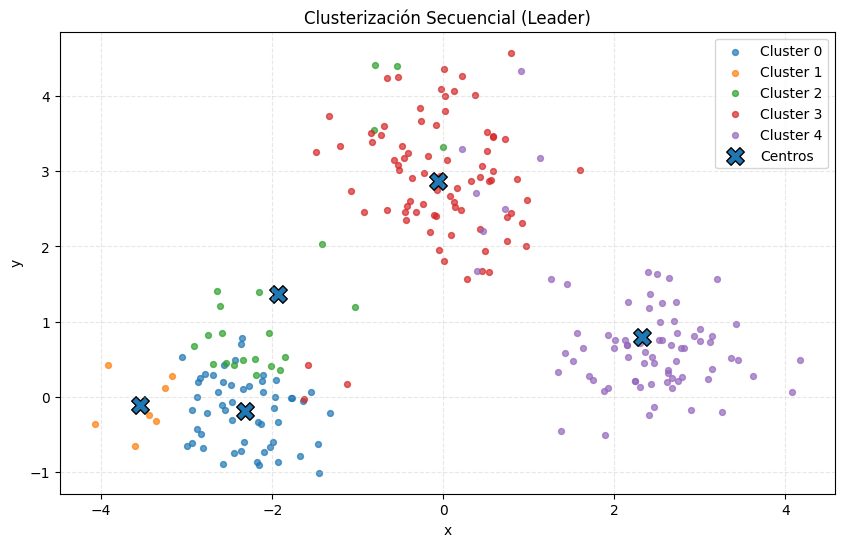

In [15]:
def graficar_clusters(datos, asignaciones, centers, title="Clusterización Secuencial (Leader)"):
    # Preparar una paleta de colores suficientemente grande (reutilizable)
    base_colors = (
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    )
    colores = [base_colors[i % len(base_colors)] for i in range(len(centers))]

    plt.figure(figsize=(10, 6))
    # Dibujar puntos por clúster
    for k in range(len(centers)):
        xs = [p[0] for p, a in zip(datos, asignaciones) if a == k]
        ys = [p[1] for p, a in zip(datos, asignaciones) if a == k]
        plt.scatter(xs, ys, s=18, alpha=0.7, label=f"Cluster {k}", color=colores[k])
    # Dibujar centros
    cx = [c[0] for c in centers]
    cy = [c[1] for c in centers]
    plt.scatter(cx, cy, s=160, marker='X', edgecolor='k', linewidths=1.0, label='Centros')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

graficar_clusters(datos, asignaciones, sc.centers)

## Efecto del radio $R$ en el número de clústeres
Comparemos con distintos valores de $R$ para ver cómo afecta la segmentación.

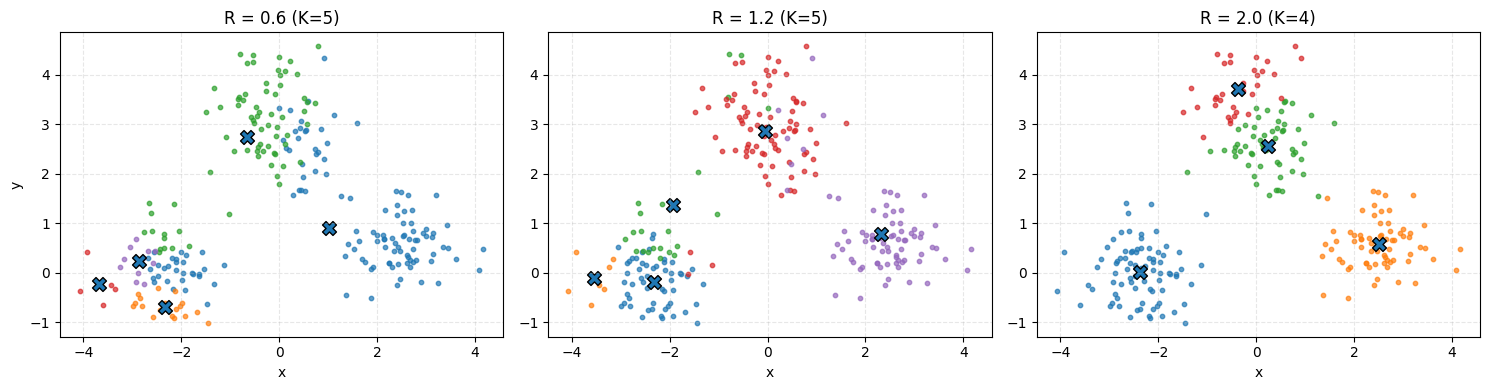

In [16]:
radios = [0.6, 1.2, 2.0]
plt.figure(figsize=(15, 4))
for i, Rtest in enumerate(radios, start=1):
    clus = SequentialClusterer(radius=Rtest)
    asg = clus.fit(datos)
    plt.subplot(1, 3, i)
    base_colors = (
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    )
    colores = [base_colors[j % len(base_colors)] for j in range(len(clus.centers))]
    for k in range(len(clus.centers)):
        xs = [p[0] for p, a in zip(datos, asg) if a == k]
        ys = [p[1] for p, a in zip(datos, asg) if a == k]
        plt.scatter(xs, ys, s=10, alpha=0.7, color=colores[k])
    cx = [c[0] for c in clus.centers]
    cy = [c[1] for c in clus.centers]
    plt.scatter(cx, cy, s=100, marker='X', edgecolor='k', linewidths=1.0)
    plt.title(f"R = {Rtest} (K={len(clus.centers)})")
    plt.xlabel('x')
    if i == 1:
        plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()